In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import matplotlib as mpl
import glob
from matplotlib.path import Path
from collections import Counter
from tqdm import tqdm

#### So this script takes you through different comparisons between fEdep spectra and TRIM simulations to determine thicknesses of the three U1-3 detectors. This is done, for each detector, for 2 different peaks using the 25Si isotope. However any isotope can be used if the analysis is run again with new peak values:
##### Note: If one wishes to do this analysis for another isotope it is important to bear in mind that you have to select banana peaks that are a good deal above the cutoff zone for the detector since you want to mainly consider peaks that have no events "lost" in the DSSSD and there is evidence, for some of the isotopes in this experiment, that there are degrees upwards of 50 degrees from the target.
##### The "arr" arrays are manually extracted, this could of course be made a lot simpler and cleaner. The TRIM simulations used for the first peak for each of the detectors is 0.2 mu larger than the states thickness since the backcontact thickness has not been taken into account.

In [2]:

## Hardcoded data paths are not ideal but whatever for now

datapath = "/home/haue/repositories/Masters/data/"
iso = "Si" 
_path = datapath + "bananas/" + iso
_p_path = datapath +"bananaexplorer/" +iso
simpath = "/home/haue/repositories/Masters/simdata/"

#outputdir = "/home/haue/repositories/Masters/analysis/python/dataquality/report_figs/"

_files = glob.glob(os.path.join(_path, "*mlio.root"))
_p_file = glob.glob(os.path.join(_p_path, "*mlio.root"))

#### Loading in of the data files storing them in a dictionary can be easily expanded to include multiple isotopes
#Could be done more optimally by doing it dynamically instead of this?
data_files = {
    iso: _files,
    "p_"+iso: _p_file,
}
data_collection = {
    iso : {},
    "p_"+iso : {}
}

data_collection = {isotope: {f"id{i}": {key: [] for key in ["E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"]} for i in range(4)} for isotope in data_files}

for isotope, files in data_files.items():
    file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files), bar_format="{l_bar}{bar} {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]")

    for file in file_progress:
        
        ## accesses the tree "a" in the root file
        r = uproot.open(file)["a"]
        ##Dummy array
        dum = r.arrays(["id", "E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"])
        
        ## converts it to an awkward array
        ids = ak.flatten(dum["id"])
        Es = ak.nan_to_num(ak.flatten(dum["E"]) / 1e3)
        fEdeps = ak.nan_to_num(ak.flatten(dum["fEdep"]) / 1e3)
        bEdeps = ak.nan_to_num(ak.flatten(dum["bEdep"]) / 1e3)
        angles = ak.nan_to_num(np.rad2deg(ak.flatten(dum["angle"])))
        Edeps = ak.nan_to_num(ak.flatten(dum["Edep"]) / 1e3)
        FIs = ak.flatten(dum["FI"])
        BIs = ak.flatten(dum["BI"])
        
        ##Creates entries in data_collection for each key and for each detector for each key
        for i in range(4):
            mask = (ids==i)
            detector_name = f"id{i}"
            data_collection[isotope][detector_name]["E"].extend(Es[mask])
            data_collection[isotope][detector_name]["fEdep"].extend(fEdeps[mask])
            data_collection[isotope][detector_name]["bEdep"].extend(bEdeps[mask])
            data_collection[isotope][detector_name]["angle"].extend(angles[mask])
            data_collection[isotope][detector_name]["Edep"].extend(Edeps[mask])
            data_collection[isotope][detector_name]["FI"].extend(FIs[mask])
            data_collection[isotope][detector_name]["BI"].extend(BIs[mask])
        file_progress.set_postfix({"Completed": f"{file_progress.n}/{file_progress.total}"})
    #print(f"Processing done for {isotope}!")

Processing Si: 100%|██████████ 11/11 [00:37<00:00,  3.43s/file]
Processing p_Si: 100%|██████████ 11/11 [00:09<00:00,  1.15file/s]


In [48]:

peaks = [(3.92,4.12), (5, 5.16), (5.22, 5.44)]
peak_vals = [4.093, 5.162, 5.415]
nr_peaks = len(peaks)

if nr_peaks != len(peak_vals) and nr_peaks != len(peaks) and len(peaks) != len(peak_vals):
    raise ValueError("The lengths of nr_peaks, peak_vals, and peaks do not match. Please set the appropriate values before continuing.")



def list_ini(n):
    return [[[] for _ in range(3)] for _ in range(n)]


### Values extracted from iso -> all values from base analysis
p_fi = list_ini(nr_peaks); p_bi=list_ini(nr_peaks); p_fedep=list_ini(nr_peaks); p_bedep=list_ini(nr_peaks)
p_app_angles=list_ini(nr_peaks)
p_posx= list_ini(nr_peaks);p_posy= list_ini(nr_peaks);p_posz= list_ini(nr_peaks)

## Values extracted from p_iso -> all values from peak analysis
p_calc_angles=list_ini(nr_peaks)


for j in range(len(peaks)):
    for i in range(3):
        det = f"id{i}"
        ## filling the values from base analysis
        for a,b,c,d,v in zip(data_collection[iso][det]["fEdep"], data_collection[iso][det]["bEdep"],
                       data_collection[iso][det]["FI"], data_collection[iso][det]["BI"],data_collection[iso][det]["angle"]):#,
                       #data_collection[iso][det]["pos.fX"],data_collection[iso][det]["pos.fY"],data_collection[iso][det]["pos.fZ"]):
            if peaks[j][0]<=a+b<=peaks[j][1]:
                p_fi[j][i].append(c)
                p_bi[j][i].append(d)
                p_fedep[j][i].append(a)
                p_bedep[j][i].append(b)
                p_app_angles[j][i].append(v)
                #p_posx[j][i].append(px)
                #p_posy[j][i].append(py)
                #p_posz[j][i].append(pz)
            else:
                continue
        for a,b,v in zip(data_collection["p_"+iso][det]["fEdep"], data_collection["p_"+iso][det]["bEdep"],
                       data_collection["p_"+iso][det]["angle"]):
            if peaks[j][0]<=a+b<=peaks[j][1]:
                p_calc_angles[j][i].append(v)



In [49]:
def convert_to_float(value):
    value = value.replace(',', '0.')
    return float(value)

trim_path = simpath+"/TRIM/"
gn = ["4MeV52mu","4MeV53mu","4MeV54mu"]
txt = ".txt"
A = ["", "5","10","15", "20", "25", "30"]
Es = []
totals = []
for g in gn:
    files = [trim_path+g+a+txt for a in A]
    energies_eV = [[_] for _ in range(len(files))]
    tot = []
    for f, i in zip(files,range(len(files))): 
        with open(f, 'r') as file:
            lines = file.readlines()
            for line in lines:
                if line.startswith('T'):
                    parts = line.strip().split()
                    if parts[1]=="4990":
                        break
                    else:
                        energy_eV = convert_to_float(parts[3])
                        energies_eV[i].append(energy_eV)
                        tot.append(energy_eV)
    Es.append([4.091-np.array(i)*1e-6 for i in energies_eV]) 
    totals.append(4.091-np.array(tot)*1e-6)
    ######## WRONG i need only subtract 2-3 keV since 12 keV is for energy also lost in back dead layer
    #I have subtracted 12 keV from 2.99 to account for the average loss due to the dead layers
    # a better implementation would be to construct the detector within the TRIM simulation and run with that

(array([0.00000000e+00, 2.26283336e-03, 6.70551889e-03, 1.14960871e-02,
        1.59611137e-02, 1.97463329e-02, 2.49741482e-02, 2.92891703e-02,
        3.39903742e-02, 3.76734626e-02, 4.24257318e-02, 4.58407272e-02,
        5.14451494e-02, 5.47675888e-02, 5.38452209e-02, 3.29563008e-02,
        2.07357240e-02, 1.21088713e-02, 3.77245280e-03, 3.19158443e-06,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([-2,  0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30,
        32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64,
        66, 68, 70]),
 [<matplotlib.patches.Polygon at 0x7f4c71e8ca60>])

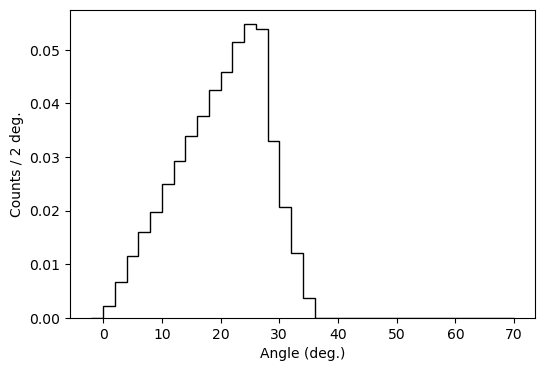

In [50]:
plt.figure(figsize=(6,4))
plt.xlabel("Angle (deg.)")
plt.ylabel("Counts / 2 deg.")
fi, bi, angs, n = np.loadtxt(simpath+"U1Ang.dat", unpack=True)
angs = np.rad2deg(angs)
angs = [a for a,f,b in zip(angs, fi, bi) if f>1 and f<16 and b>1 and b<16]
plt.hist(angs, bins=np.arange(-2,72,2), histtype='step', color='k', density=True, label="Simmed ")
#2.26283336e-03, (1.14960871e-02+1.59611137e-02)/2, 2.49741482e-02, (3.39903742e-02+3.76734626e-02)/2, 4.58407272e-02,5.47675888e-02+5.38452209e-02/2, 2.07357240e-02

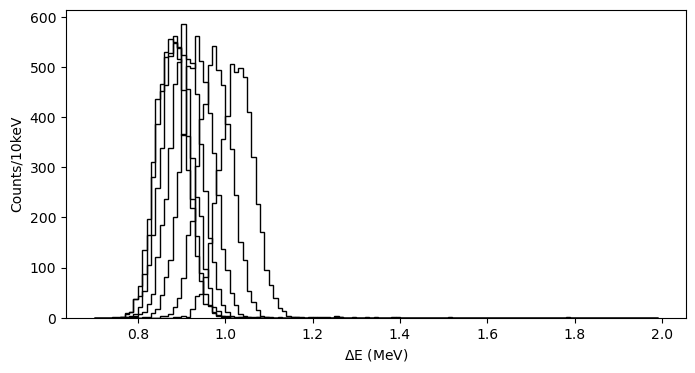

In [51]:

plt.figure(figsize=(8,4))
plt.xlabel(r"$\Delta$E (MeV)")
plt.ylabel("Counts/10keV")
for e in Es[0]:
    plt.hist(e, bins=np.arange(0.7,2, 0.01), histtype='step', color='k')



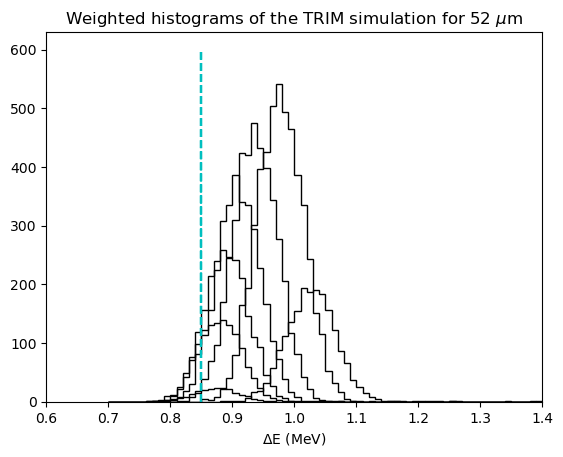

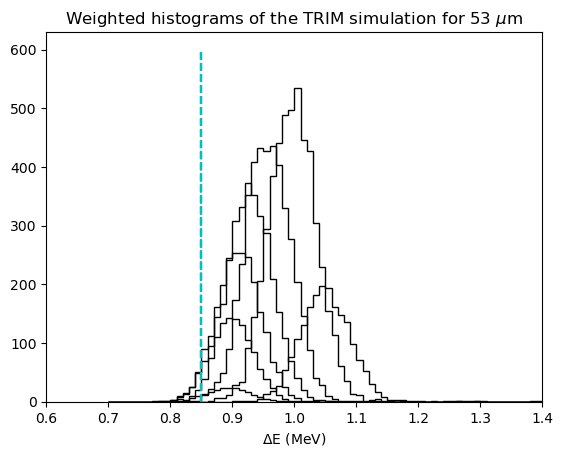

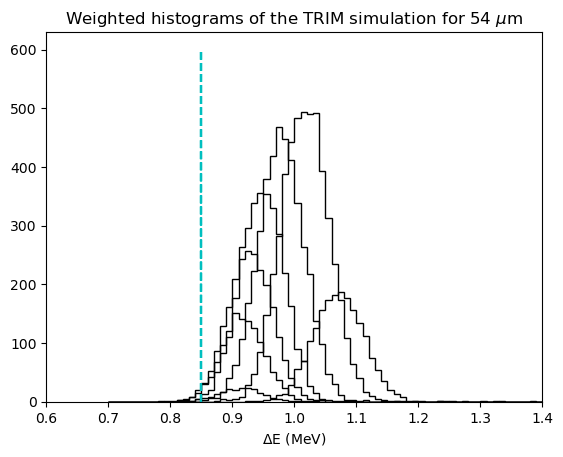

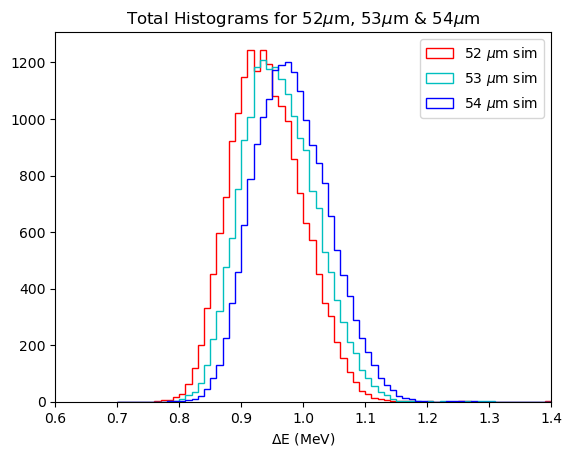

[0.00226283336, 0.0137286004, 0.0249741482, 0.035831918399999996, 0.0458407272, 0.054306404850000004, 0.020735724]


In [52]:
#arr = [2.26283336e-03, 3.76734626e-02, 4.58407272e-02, 5.47675888e-02, 2.07357240e-02] ## 0,10,20,25,30
#arr = [2.26283336e-03, 2.49741482e-02,4.58407272e-02,(5.47675888e-02+5.38452209e-02)/2, 2.07357240e-02]
arr = [2.26283336e-03, (1.14960871e-02+1.59611137e-02)/2, 2.49741482e-02, (3.39903742e-02+3.76734626e-02)/2, 4.58407272e-02,(5.47675888e-02+5.38452209e-02)/2, 2.07357240e-02]
tots = []

for i in range(len(Es)):
    plt.figure()
    total_hist = np.zeros(len(np.arange(0.7, 2, 0.01)) - 1)
    for j, r in zip(range(len(Es[i])),arr):
        rel_hist, bin_edges = np.histogram(Es[i][j], bins=np.arange(0.7,2, 0.01))
        maxval = np.max(arr)
        relsize = r/maxval
        rel_hist = rel_hist*relsize
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.hist(bin_edges[:-1], bins=bin_edges, weights=rel_hist, histtype='step', color='k')
        total_hist += rel_hist
        plt.vlines(0.914*0.93, 0, 600, ls='--', color='c', label=r"Cutoff fedep for 53$\mu$m")
    plt.xlim(0.6,1.4)
    tots.append(total_hist)
    plt.xlabel(r"$\Delta$E (MeV)")
    plt.title(rf"Weighted histograms of the TRIM simulation for {i+52} $\mu$m")

plt.figure()
bin_edges = np.arange(0.7, 2, 0.01)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[0], histtype='step', color='r', label=r"52 $\mu$m sim")
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[1], histtype='step', color='c', label=r"53 $\mu$m sim")
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[2], histtype='step', color='b', label=r"54 $\mu$m sim")
plt.xlim(0.6,1.4)
plt.title(r"Total Histograms for 52$\mu$m, 53$\mu$m & 54$\mu$m")
plt.xlabel(r"$\Delta$E (MeV)")
plt.legend()
plt.show()
len(tots)
print(arr)

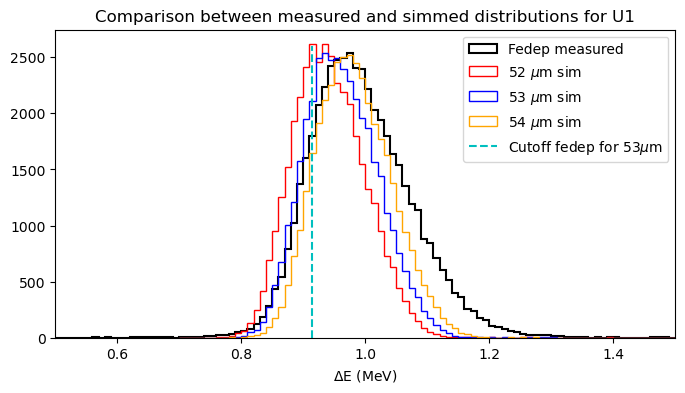

In [53]:
plt.figure(figsize=(8,4))
plt.xlabel(r"$\Delta$E (MeV)")
plt.title("Comparison between measured and simmed distributions for U1")
#plt.ylabel("Counts/10keV")
#plt.yscale('log')
plt.hist(p_fedep[0][0], bins=np.arange(0,3, 0.01), histtype='step', color='k', label=f"Fedep measured", lw=1.5)
bin_edges = np.arange(0.7, 2, 0.01)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
scale = 2.1
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[0]*scale, histtype='step', color='r', label=r"52 $\mu$m sim")
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[1]*scale, histtype='step', color='b', label=r"53 $\mu$m sim")
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[2]*scale, histtype='step', color='orange', label=r"54 $\mu$m sim")

plt.xlim(0.5, 1.5)
#plt.ylim(1, 1e4)
plt.vlines(0.914, 0, 2600, ls='--', color='c', label=r"Cutoff fedep for 53$\mu$m")
plt.legend()

plt.show()



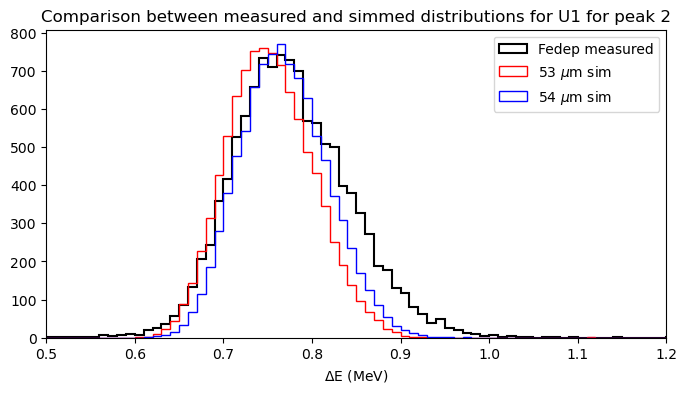

In [69]:
def convert_to_float(value):
    value = value.replace(',', '0.')
    return float(value)

trim_path = simpath+"/TRIM/"
gn = ["5.4MeV53mu","5.4MeV54mu"]
txt = ".txt"
A = ["", "5","10","15", "20", "25", "30"]
#A = ["","10", "20", "25", "30"]
Es = []
totals = []
for g in gn:
    files = [trim_path+g+a+txt for a in A]
    energies_eV = [[_] for _ in range(len(files))]
    tot = []
    for f, i in zip(files,range(len(files))): 
        with open(f, 'r') as file:
            lines = file.readlines()
            for line in lines:
                if line.startswith('T'):
                    parts = line.strip().split()
                    if parts[1]=="4990":
                        break
                    else:
                        energy_eV = convert_to_float(parts[3])
                        energies_eV[i].append(energy_eV)
                        tot.append(energy_eV)
    Es.append([peak_vals[2]-np.array(i)*1e-6 for i in energies_eV]) 
    totals.append(peak_vals[2]-np.array(tot)*1e-6)
arr = [2.26283336e-03, (1.14960871e-02+1.59611137e-02)/2, 2.49741482e-02, (3.39903742e-02+3.76734626e-02)/2, 4.58407272e-02,(5.47675888e-02+5.38452209e-02)/2, 2.07357240e-02]
#arr = [ 0.00254308, 0.015,0.02049953,0.035, 0.04777833, 0.05702841, 0.02106046]

tots = []

for i in range(len(Es)):
    total_hist = np.zeros(len(np.arange(0., 2, 0.01)) - 1)
    for j, r in zip(range(len(Es[i])),arr):
        rel_hist, bin_edges = np.histogram(Es[i][j], bins=np.arange(0.,2, 0.01))
        maxval = np.max(arr)
        relsize = r/maxval
        rel_hist = rel_hist*relsize
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        total_hist += rel_hist
    tots.append(total_hist)

bin_edges = np.arange(0., 2, 0.01)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

len(tots)
plt.figure(figsize=(8,4))
plt.xlabel(r"$\Delta$E (MeV)")
plt.title("Comparison between measured and simmed distributions for U1 for peak 2")
plt.hist(p_fedep[2][0], bins=np.arange(0,3, 0.01), histtype='step', color='k', label=f"Fedep measured", lw=1.5)
bin_edges = np.arange(0., 2, 0.01)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
scale = 0.52
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[0]*scale, histtype='step', color='r', label=r"53 $\mu$m sim")
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[1]*scale, histtype='step', color='b', label=r"54 $\mu$m sim")
#plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[2]*scale, histtype='step', color='orange', label=r"69 $\mu$m sim")
plt.xlim(0.5, 1.2)
#plt.vlines(0.914, 0, 2600, ls='--', color='c', label=r"Cutoff fedep for 53$\mu$m")
plt.legend()
plt.show()



(array([0.        , 0.00254308, 0.00738148, 0.01257433, 0.01726131,
        0.01922283, 0.02049953, 0.02666969, 0.03276759, 0.03795012,
        0.04267495, 0.04777833, 0.05244466, 0.05702841, 0.05334971,
        0.03375179, 0.02106046, 0.0117622 , 0.00327951, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 array([-2,  0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30,
        32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64,
        66, 68, 70]),
 [<matplotlib.patches.Polygon at 0x7f3474315960>])

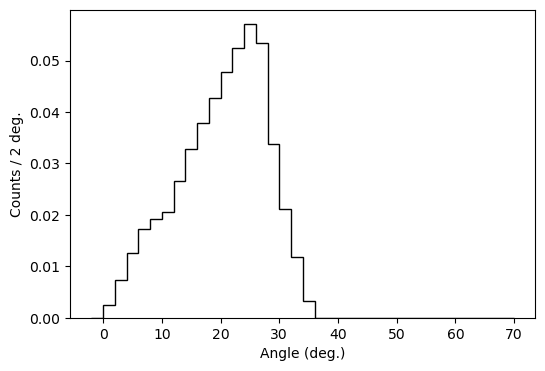

In [27]:
plt.figure(figsize=(6,4))
plt.xlabel("Angle (deg.)")
plt.ylabel("Counts / 2 deg.")
fi, bi, angs, n = np.loadtxt(simpath+"U2Ang.dat", unpack=True)
angs = np.rad2deg(angs)
angs = [a for a,f,b in zip(angs, fi, bi) if f>1 and f<16 and b>1 and b<16]
plt.hist(angs, bins=np.arange(-2,72,2), histtype='step', color='k', density=True, label="Simmed ")
# 0.00254308, 0.01257433+0.01726131/2, 0.02049953,0.03276759+0.03795012/2, 0.04777833, 0.05702841+0.05334971/2, 0.02106046

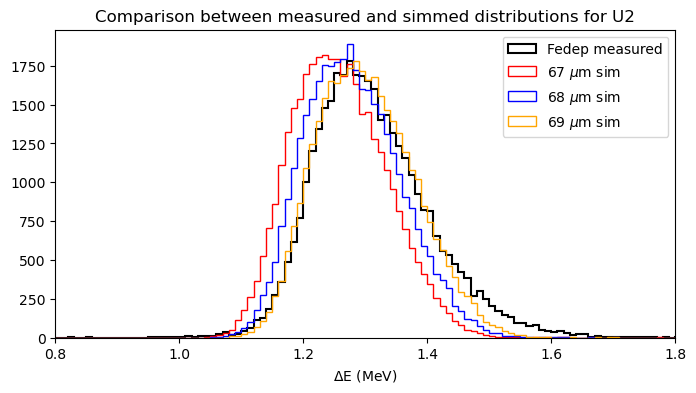

In [ ]:
def convert_to_float(value):
    value = value.replace(',', '0.')
    return float(value)

trim_path = simpath+"/TRIM/"
gn = ["4MeV67mu","4MeV68mu","4MeV69mu"]
txt = ".txt"
A = ["", "5","10","15", "20", "25", "30"]
#A = ["","10", "20", "25", "30"]
Es = []
totals = []
for g in gn:
    files = [trim_path+g+a+txt for a in A]
    energies_eV = [[_] for _ in range(len(files))]
    tot = []
    for f, i in zip(files,range(len(files))): 
        with open(f, 'r') as file:
            lines = file.readlines()
            for line in lines:
                if line.startswith('T'):
                    parts = line.strip().split()
                    if parts[1]=="4990":
                        break
                    else:
                        energy_eV = convert_to_float(parts[3])
                        energies_eV[i].append(energy_eV)
                        tot.append(energy_eV)
    Es.append([peak_vals[0]-np.array(i)*1e-6 for i in energies_eV]) 
    totals.append(peak_vals[0]-np.array(tot)*1e-6)
arr=[0.00254308, (0.01257433+0.01726131)/2, 0.02049953,(0.03276759+0.03795012)/2, 0.04777833, (0.05702841+0.05334971)/2, 0.02106046]
#arr = [ 0.00254308, 0.015,0.02049953,0.035, 0.04777833, 0.05702841, 0.02106046]

tots = []

for i in range(len(Es)):
    total_hist = np.zeros(len(np.arange(0.7, 2, 0.01)) - 1)
    for j, r in zip(range(len(Es[i])),arr):
        rel_hist, bin_edges = np.histogram(Es[i][j], bins=np.arange(0.7,2, 0.01))
        maxval = np.max(arr)
        relsize = r/maxval
        rel_hist = rel_hist*relsize
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        total_hist += rel_hist
    tots.append(total_hist)

bin_edges = np.arange(0.7, 2, 0.01)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

len(tots)
plt.figure(figsize=(8,4))
plt.xlabel(r"$\Delta$E (MeV)")
plt.title("Comparison between measured and simmed distributions for U2")
plt.hist(p_fedep[0][1], bins=np.arange(0,3, 0.01), histtype='step', color='k', label=f"Fedep measured", lw=1.5)
bin_edges = np.arange(0.7, 2, 0.01)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
scale = 2.02
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[0]*scale, histtype='step', color='r', label=r"67 $\mu$m sim")
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[1]*scale, histtype='step', color='b', label=r"68 $\mu$m sim")
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[2]*scale, histtype='step', color='orange', label=r"69 $\mu$m sim")
plt.xlim(0.8, 1.8)
#plt.vlines(0.914, 0, 2600, ls='--', color='c', label=r"Cutoff fedep for 53$\mu$m")
plt.legend()
plt.show()



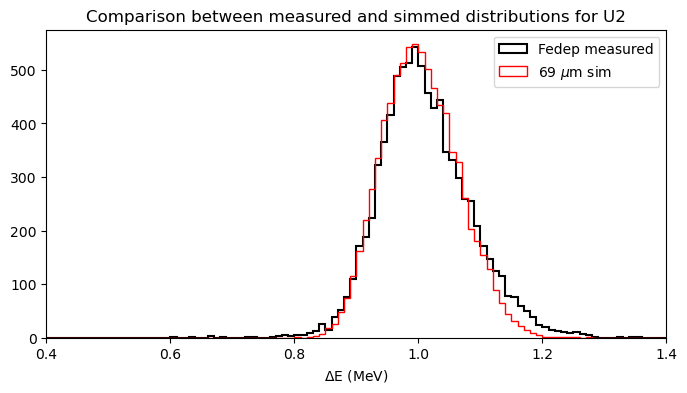

In [63]:
def convert_to_float(value):
    value = value.replace(',', '0.')
    return float(value)

trim_path = simpath+"/TRIM/"
gn = ["5.4MeV69mu"]#,"5.4MeV69mu"] # 70?
txt = ".txt"
A = ["", "5","10","15", "20", "25", "30"]
#A = ["","10", "20", "25", "30"]
Es = []
totals = []
for g in gn:
    files = [trim_path+g+a+txt for a in A]
    energies_eV = [[_] for _ in range(len(files))]
    tot = []
    for f, i in zip(files,range(len(files))): 
        with open(f, 'r') as file:
            lines = file.readlines()
            for line in lines:
                if line.startswith('T'):
                    parts = line.strip().split()
                    if parts[1]=="4990":
                        break
                    else:
                        energy_eV = convert_to_float(parts[3])
                        energies_eV[i].append(energy_eV)
                        tot.append(energy_eV)
    Es.append([peak_vals[2]-np.array(i)*1e-6 for i in energies_eV]) 
    totals.append(peak_vals[2]-np.array(tot)*1e-6)
arr=[0.00254308, (0.01257433+0.01726131)/2, 0.02049953,(0.03276759+0.03795012)/2, 0.04777833, (0.05702841+0.05334971)/2, 0.02106046]
#arr = [ 0.00254308, 0.015,0.02049953,0.035, 0.04777833, 0.05702841, 0.02106046]

tots = []

for i in range(len(Es)):
    total_hist = np.zeros(len(np.arange(0., 2, 0.01)) - 1)
    for j, r in zip(range(len(Es[i])),arr):
        rel_hist, bin_edges = np.histogram(Es[i][j], bins=np.arange(0.,2, 0.01))
        maxval = np.max(arr)
        relsize = r/maxval
        rel_hist = rel_hist*relsize
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        total_hist += rel_hist
    tots.append(total_hist)

bin_edges = np.arange(0., 2, 0.01)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

len(tots)
plt.figure(figsize=(8,4))
plt.xlabel(r"$\Delta$E (MeV)")
plt.title("Comparison between measured and simmed distributions for U2")
plt.hist(p_fedep[2][1], bins=np.arange(0,3, 0.01), histtype='step', color='k', label=f"Fedep measured", lw=1.5)
bin_edges = np.arange(0., 2, 0.01)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
scale = 0.475
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[0]*scale, histtype='step', color='r', label=r"69 $\mu$m sim")
#plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[1]*scale, histtype='step', color='b', label=r"68 $\mu$m sim")
#plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[2]*scale, histtype='step', color='orange', label=r"69 $\mu$m sim")
plt.xlim(0.4, 1.4)
#plt.vlines(0.914, 0, 2600, ls='--', color='c', label=r"Cutoff fedep for 53$\mu$m")
plt.legend()
plt.show()



(array([0.        , 0.00216514, 0.00707405, 0.01155057, 0.01601437,
        0.02079293, 0.02525355, 0.02963151, 0.03434966, 0.03809811,
        0.04263504, 0.04758847, 0.05160716, 0.05576893, 0.05246876,
        0.03164086, 0.01947032, 0.01090516, 0.00298541, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 array([-2,  0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30,
        32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64,
        66, 68, 70]),
 [<matplotlib.patches.Polygon at 0x7f347ff72890>])

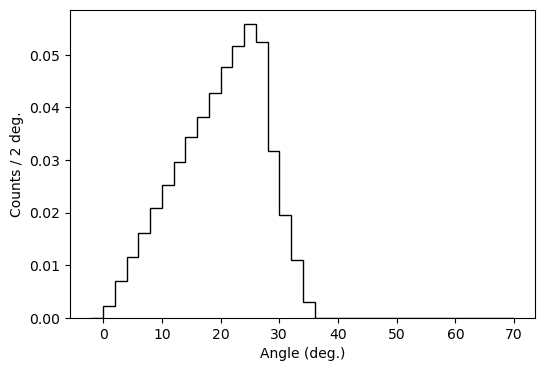

In [29]:
plt.figure(figsize=(6,4))
plt.xlabel("Angle (deg.)")
plt.ylabel("Counts / 2 deg.")
fi, bi, angs, n = np.loadtxt(simpath+"U3Ang.dat", unpack=True)
angs = np.rad2deg(angs)
angs = [a for a,f,b in zip(angs, fi, bi) if f>1 and f<16 and b>1 and b<16]
plt.hist(angs, bins=np.arange(-2,72,2), histtype='step', color='k', density=True, label="Simmed ")
# 0.00216514, 0.01601437+0.01155057/2, 0.02525355, 0.03434966+0.03809811/2, 0.04758847, 
# 0.05576893+0.05246876/2, 0.01947032

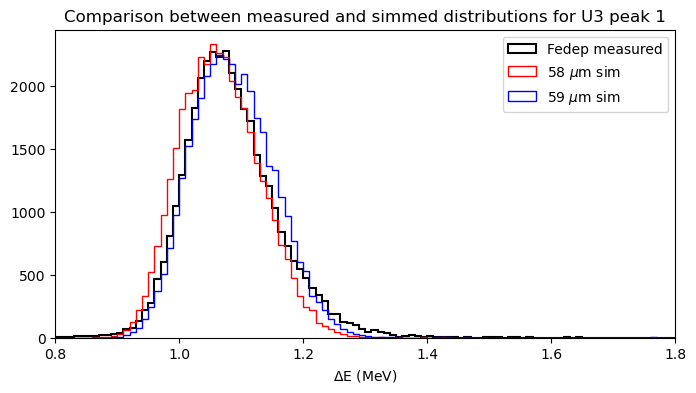

In [68]:
def convert_to_float(value):
    value = value.replace(',', '0.')
    return float(value)

trim_path = simpath+"/TRIM/"
gn = ["4MeV58mu","4MeV59mu"]#,"4MeV69mu"]
txt = ".txt"
A = ["", "5","10","15", "20", "25", "30"]
#A = ["","10", "20", "25", "30"]
Es = []
totals = []
for g in gn:
    files = [trim_path+g+a+txt for a in A]
    energies_eV = [[_] for _ in range(len(files))]
    tot = []
    for f, i in zip(files,range(len(files))): 
        with open(f, 'r') as file:
            lines = file.readlines()
            for line in lines:
                if line.startswith('T'):
                    parts = line.strip().split()
                    if parts[1]=="4990":
                        break
                    else:
                        energy_eV = convert_to_float(parts[3])
                        energies_eV[i].append(energy_eV)
                        tot.append(energy_eV)
    Es.append([4.091-np.array(i)*1e-6 for i in energies_eV]) 
    totals.append(4.091-np.array(tot)*1e-6)
#arr = [2.26283336e-03, 3.76734626e-02, 4.58407272e-02, 5.47675888e-02, 2.07357240e-02] ## 0,10,20,25,30
arr = [ 0.00254308, 0.015,0.02049953,0.035, 0.04777833, 0.05702841, 0.02106046]

tots = []

for i in range(len(Es)):
    total_hist = np.zeros(len(np.arange(0.7, 2, 0.01)) - 1)
    for j, r in zip(range(len(Es[i])),arr):
        rel_hist, bin_edges = np.histogram(Es[i][j], bins=np.arange(0.7,2, 0.01))
        maxval = np.max(arr)
        relsize = r/maxval
        rel_hist = rel_hist*relsize
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        total_hist += rel_hist
    tots.append(total_hist)

bin_edges = np.arange(0.7, 2, 0.01)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

len(tots)

plt.figure(figsize=(8,4))
plt.xlabel(r"$\Delta$E (MeV)")
plt.title("Comparison between measured and simmed distributions for U3 peak 1")
plt.hist(p_fedep[0][2], bins=np.arange(0,3, 0.01), histtype='step', color='k', label=f"Fedep measured", lw=1.5)
bin_edges = np.arange(0.7, 2, 0.01)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
scale = 2.18
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[0]*scale, histtype='step', color='r', label=r"58 $\mu$m sim")
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[1]*scale, histtype='step', color='b', label=r"59 $\mu$m sim")
#plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[2]*scale, histtype='step', color='orange', label=r"69 $\mu$m sim")
plt.xlim(0.8, 1.8)
#plt.vlines(0.914, 0, 2600, ls='--', color='c', label=r"Cutoff fedep for 53$\mu$m")
plt.legend()

plt.show()



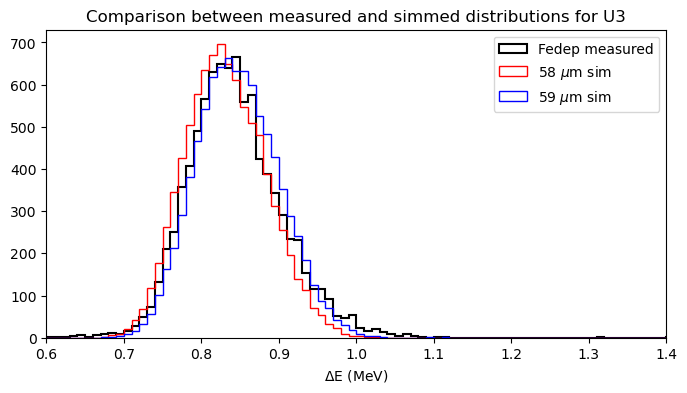

In [38]:
def convert_to_float(value):
    value = value.replace(',', '0.')
    return float(value)

trim_path = simpath+"/TRIM/"
gn = ["5.4MeV58mu","5.4MeV59mu"]#,"4MeV69mu"]
txt = ".txt"
A = ["", "5","10","15", "20", "25", "30"]
#A = ["","10", "20", "25", "30"]
Es = []
totals = []
for g in gn:
    files = [trim_path+g+a+txt for a in A]
    energies_eV = [[_] for _ in range(len(files))]
    tot = []
    for f, i in zip(files,range(len(files))): 
        with open(f, 'r') as file:
            lines = file.readlines()
            for line in lines:
                if line.startswith('T'):
                    parts = line.strip().split()
                    if parts[1]=="4990":
                        break
                    else:
                        energy_eV = convert_to_float(parts[3])
                        energies_eV[i].append(energy_eV)
                        tot.append(energy_eV)
    Es.append([peak_vals[2]-np.array(i)*1e-6 for i in energies_eV]) 
    totals.append(peak_vals[2]-np.array(tot)*1e-6)
#arr = [2.26283336e-03, 3.76734626e-02, 4.58407272e-02, 5.47675888e-02, 2.07357240e-02] ## 0,10,20,25,30
arr = [ 0.00254308, 0.015,0.02049953,0.035, 0.04777833, 0.05702841, 0.02106046]



tots = []

for i in range(len(Es)):
    total_hist = np.zeros(len(np.arange(0, 3, 0.01)) - 1)
    for j, r in zip(range(len(Es[i])),arr):
        rel_hist, bin_edges = np.histogram(Es[i][j], bins=np.arange(0,3, 0.01))
        maxval = np.max(arr)
        relsize = r/maxval
        rel_hist = rel_hist*relsize
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        total_hist += rel_hist
    tots.append(total_hist)

bin_edges = np.arange(0.7, 2, 0.01)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

len(tots)

plt.figure(figsize=(8,4))
plt.xlabel(r"$\Delta$E (MeV)")
plt.title("Comparison between measured and simmed distributions for U3 peak 3")
plt.hist(p_fedep[2][2], bins=np.arange(0,3, 0.01), histtype='step', color='k', label=f"Fedep measured", lw=1.5)
bin_edges = np.arange(0, 3, 0.01)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
scale = 0.515
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[0]*scale, histtype='step', color='r', label=r"58 $\mu$m sim")
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[1]*scale, histtype='step', color='b', label=r"59 $\mu$m sim")
#plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[2]*scale, histtype='step', color='orange', label=r"69 $\mu$m sim")
plt.xlim(0.6, 1.4)
#plt.vlines(0.914, 0, 2600, ls='--', color='c', label=r"Cutoff fedep for 53$\mu$m")
plt.legend()

plt.show()

